In [125]:
# As usual, a bit of setup
%load_ext autoreload
%autoreload 2
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from nnet.data.data_utils import get_CIFAR10_data
from nnet.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from nnet.solver import Solver
from nnet.data.data_utils import load_CIFAR10
from nnet.res_net import ResNet
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')


plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-2, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data(
    num_training=50000, num_validation=0, num_test=1000)

for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (0, 3, 32, 32)
X_train:  (50000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (0,)
y_train:  (50000,)
y_test:  (1000,)


# nSize = 1, nPad = 2

Update Rule: sgd_th;
- Optim Config: {'nesterov': True, 'learning_rate': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9};
- Learning Rate Decay: 1;
- Batch Size: 50;
- Number of Epochs: 160; 160000 iterations (1000 it/epoch)
- Print every: 100

Output example: 

[....]

2016-03-08 08:52:06.093153: Step 151000, loss: 0.477 train acc: 0.821; val_acc: 0.802 (0.89 sec/batch)

*Epoch 150 / 160 Ended: best_val_acc: 0.808000

2016-03-08 08:52:19.732056: Step 151001, loss: 0.577 train acc: 0.818; val_acc: 0.804 (0.89 sec/batch)

2016-03-08 08:53:38.950771: Step 151101, loss: 0.477 train acc: 0.817; val_acc: 0.800 (0.89 sec/batch)

2016-03-08 08:54:58.928264: Step 151201, loss: 0.469 train acc: 0.811; val_acc: 0.800 (0.89 sec/batch)

2016-03-08 08:56:19.087227: Step 151301, loss: 0.451 train acc: 0.823; val_acc: 0.804 (0.90 sec/batch)

2016-03-08 08:57:36.998881: Step 151401, loss: 0.591 train acc: 0.809; val_acc: 0.801 (0.87 sec/batch)

2016-03-08 08:58:54.438577: Step 151501, loss: 0.714 train acc: 0.824; val_acc: 0.800 (0.87 sec/batch)

2016-03-08 09:00:11.186538: Step 151601, loss: 0.325 train acc: 0.827; val_acc: 0.799 (0.86 sec/batch)

2016-03-08 09:01:27.843255: Step 151701, loss: 0.537 train acc: 0.827; val_acc: 0.800 (0.87 sec/batch)

2016-03-08 09:02:44.510494: Step 151801, loss: 0.503 train acc: 0.815; val_acc: 0.802 (0.87 sec/batch)

2016-03-08 09:04:01.371845: Step 151901, loss: 0.626 train acc: 0.829; val_acc: 0.805 (0.87 sec/batch)

2016-03-08 09:05:17.367586: Step 152000, loss: 0.886 train acc: 0.815; val_acc: 0.800 (0.87 sec/batch)

*Epoch 151 / 160 Ended: best_val_acc: 0.808000

2016-03-08 09:05:30.458171: Step 152001, loss: 0.585 train acc: 0.833; val_acc: 0.800 (0.87 sec/batch)

2016-03-08 09:06:47.099039: Step 152101, loss: 0.585 train acc: 0.829; val_acc: 0.799 (0.87 sec/batch)

[....]

##### So we have to remove first (or last) check every 10 checks, additionally, given the batch size is small, we should remove some loss checks too, one every ~128/50 (=2.56).

In [128]:
num_train = 50000
data = get_CIFAR10_data(
    num_training=50000, num_validation=0, num_test=1000)

data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_test'],
    'y_val': data['y_test'],
}

model = ResNet(n_size=1, num_starting_filters=16)

solver = Solver(model, data, load_dir='checkpoints')

## Total training loss and train/ val errors

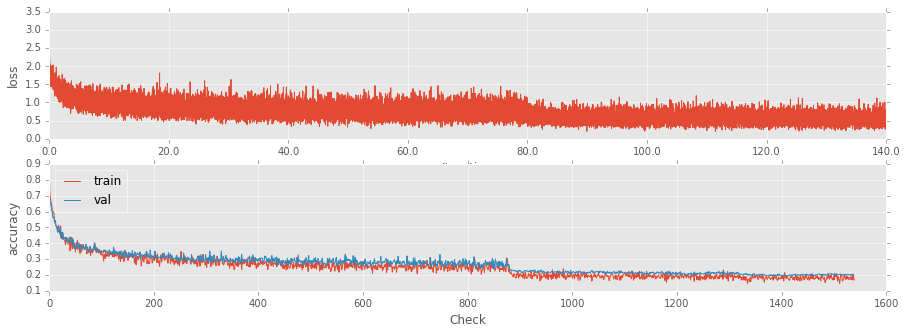

In [6]:
loss_history = np.array(solver.loss_history)[::4]


train_err_history = 1 - np.array(solver.train_acc_history)[::1]
val_err_history = 1 - np.array(solver.val_acc_history)[1::1]


ax = plt.subplot(2, 1, 1)
#plt.grid(True, color='w', linestyle='-', linewidth=.5)
#plt.gca().patch.set_facecolor('0.9')
plt.plot(loss_history)
ticks = ax.get_xticks()*4./1000.
ax.set_xticklabels(ticks)
plt.ylabel('loss')
plt.xlabel('Iteration')

ax = plt.subplot(2, 1, 2)
#plt.grid(True, color='w', linestyle='-', linewidth=.5)
#plt.gca().patch.set_facecolor('0.9')
plt.plot(train_err_history)
plt.plot(val_err_history)

plt.ylabel('accuracy')
plt.xlabel('Check')
plt.legend(['train', 'val'], loc='upper left')

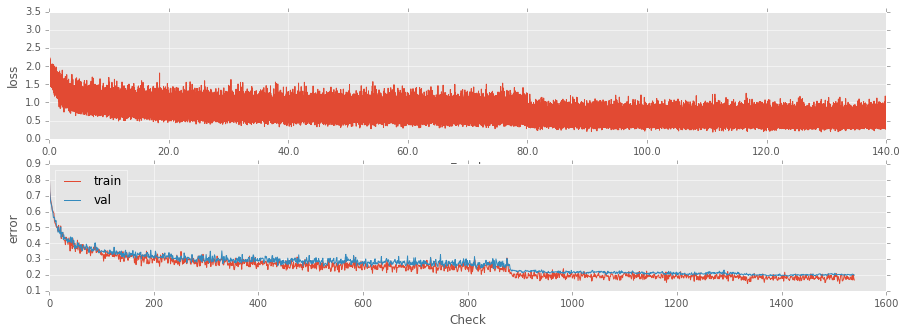

In [81]:
scale = 1.

loss_history = np.array(solver.loss_history)[::scale]
train_err_history = 1 - np.array(solver.train_acc_history)
val_err_history = 1 - np.array(solver.val_acc_history)


ax = plt.subplot(2, 1, 1)

plt.plot(loss_history)


#import pdb; pdb.set_trace()
ticks = ax.get_xticks()*scale/1000.
ax.set_xticklabels(ticks)


plt.ylabel('loss')
plt.xlabel('Epoch')

plt.subplot(2, 1, 2)

plt.plot(train_err_history)
plt.plot(val_err_history)
plt.ylabel('error')
plt.xlabel('Check')
plt.legend(['train', 'val'], loc='upper left')



## Training and Testing error

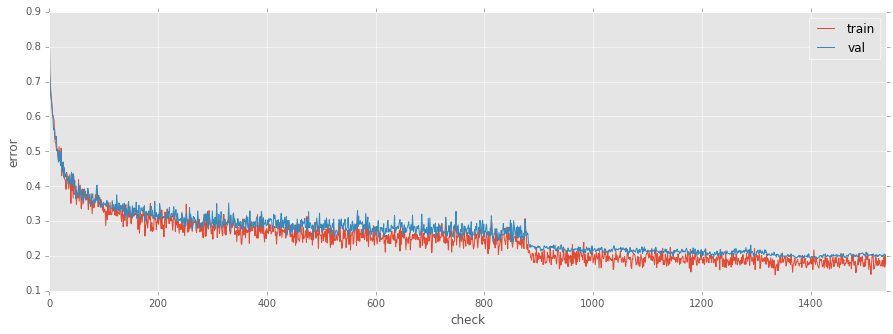

In [80]:


train_err_history = 1 - np.array(solver.train_acc_history)
val_err_history = 1 - np.array(solver.val_acc_history)


ts = pd.DataFrame(zip(train_err_history, val_err_history), columns=['train', 'val'])
ts.plot()
plt.ylabel('error')
plt.xlabel('check')

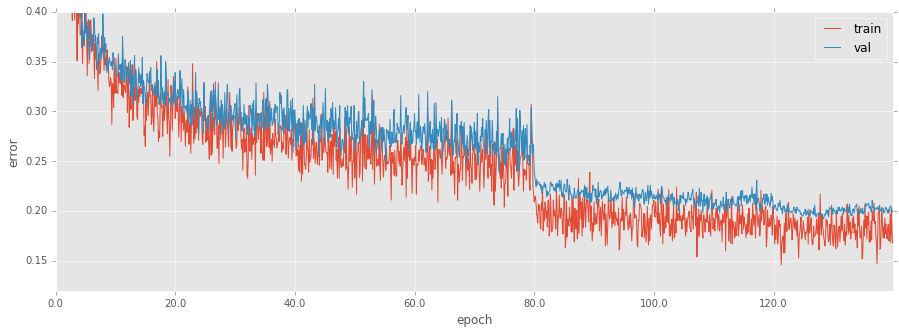

In [79]:

train_err_history = 1 - np.array(solver.train_acc_history)
val_err_history = 1 - np.array(solver.val_acc_history)

mask = np.array(range(len(val_err_history))[::11]) #remove unwanted checks

train_err_history = np.delete(train_err_history, mask)
val_err_history = np.delete(val_err_history, mask)



# df.plot(subplots=True, layout=(2, 3), figsize=(6, 6), sharex=False);
ts = pd.DataFrame(zip(train_err_history, val_err_history), columns=['train', 'val'])

ax = ts.plot()
#ax.set_xlim(pd.Timestamp('2015-02-15'), pd.Timestamp('2015-07-01'))
ax.set_ylim(0.12, 0.4)
ticks = ax.get_xticks()/10.
ax.set_xticklabels(ticks)
plt.ylabel('error')
plt.xlabel('epoch')

## Testing Error

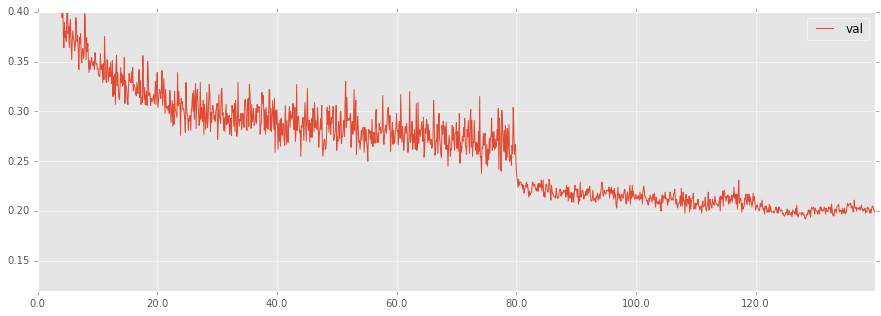

In [58]:

val_err_history = 1 - np.array(solver.val_acc_history)

mask = np.array(range(len(val_err_history))[::11]) #remove unwanted checks

train_err_history = np.delete(train_err_history, mask)
val_err_history = np.delete(val_err_history, mask)



# df.plot(subplots=True, layout=(2, 3), figsize=(6, 6), sharex=False);
ts = pd.DataFrame(val_err_history, columns=['val'])

ax = ts.plot()
#ax.set_xlim(pd.Timestamp('2015-02-15'), pd.Timestamp('2015-07-01'))
ax.set_ylim(0.12, 0.4)
ticks = ax.get_xticks()/10.
ax.set_xticklabels(ticks)

## Testing Loss

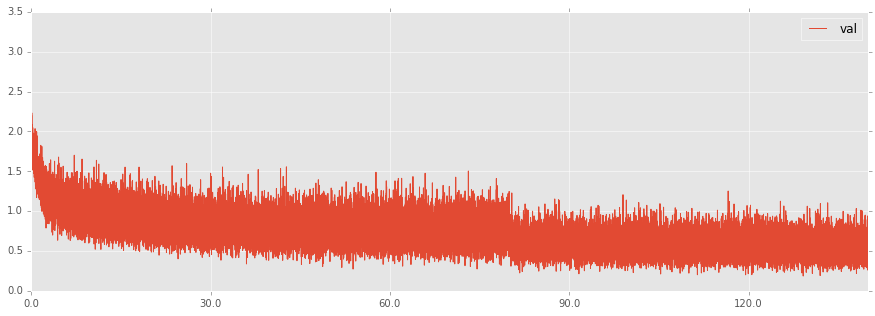

In [68]:
scale = 3 # as if there was a batch size of ~128
loss_history = np.array(solver.loss_history)[::scale]

#remove unwanted checks


# df.plot(subplots=True, layout=(2, 3), figsize=(6, 6), sharex=False);
ts = pd.DataFrame(loss_history, columns=['val'])

ax = ts.plot()
#ax.set_xlim(pd.Timestamp('2015-02-15'), pd.Timestamp('2015-07-01'))
#ax.set_ylim(0.12, 0.4)
ticks = ax.get_xticks()*scale/1000.
ax.set_xticklabels(ticks)

# Weights visualization


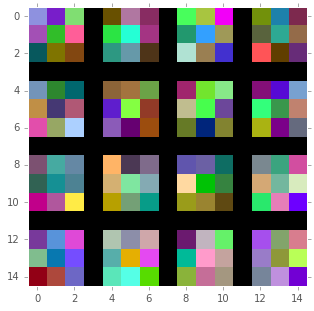

In [127]:
from nnet.utils.vis_utils import visualize_grid
#print dir(matplotlib.style)

#matplotlib.style.use('classic')
plt.grid(True, color='w', linestyle='-', linewidth=0)
#plt.rcParams['figure.figsize'] = (5.0, 5.0)

grid = visualize_grid(solver.model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))

# Not Recognized Samples

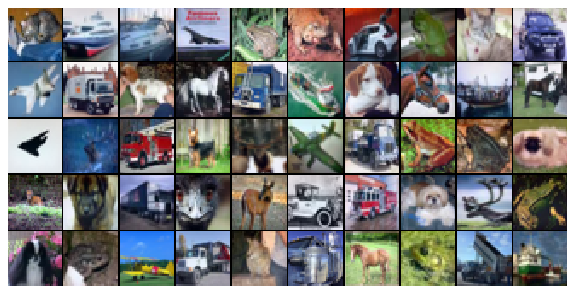

In [137]:
# train
from nnet.utils.vis_utils import visualize_grid

#grid = visualize_grid(best_model['W1'].transpose(0, 2, 3, 1))

#plt.imshow(grid.astype('uint8'))
solver.num_processes = 2
predictions = solver.check_accuracy(data['X_val'], data['y_val'], return_preds=True)
wrong_pred = np.where((predictions == data['y_val']) == False )


grid = visualize_grid(data['X_val'][wrong_pred].transpose(0, 2, 3, 1), grid_size=(10,5))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.set_xticks([])
ax.set_yticks([])


plt.imshow(grid.astype('uint8'))

#plt.savefig('mini_resnet_overfitting_images.png', dpi=100)


#grid = visualize_grid(best_model['W1'].transpose(0, 2, 3, 1))
#plt.imshow(grid.astype('uint8'))
